In [1]:
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def function_gen(x, a, b, c, d):
    y1 = a*x**2 +b*x+c
    y2 = d*x**3 + c*x**2 + b*x+a
    return y1, y2

In [3]:
x = np.linspace(0,1,100)

y1 = []
y2 = []
a = []
b = []
c = []
d = []

for i in range(10000):

    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)

    y1_, y2_ = function_gen(x, a_, b_, c_, d_)
    
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

In [4]:
reg1 = np.polyfit(x,y1[0],3)

In [5]:
reg1

array([2.10519057e-14, 6.62710442e+00, 5.73351022e-01, 4.46837627e+00])

In [6]:
print(a[0],b[0],c[0],d[0])

[6.62710442] [0.57335102] [4.46837627] [0.05529031]


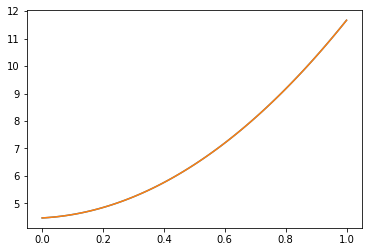

In [7]:
plt.plot(x, np.polyval(reg1,x))
plt.plot(x, y1[0])

In [8]:
reg2 = np.polyfit(x,y2[0],4)

In [9]:
reg2

array([7.78596175e-14, 5.52903145e-02, 4.46837627e+00, 5.73351022e-01,
       6.62710442e+00])

In [10]:
print(a[0],b[0],c[0],d[0])

[6.62710442] [0.57335102] [4.46837627] [0.05529031]


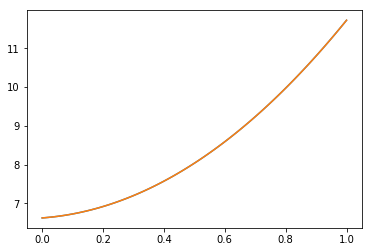

In [11]:
plt.plot(x, np.polyval(reg2,x))
plt.plot(x, y2[0])

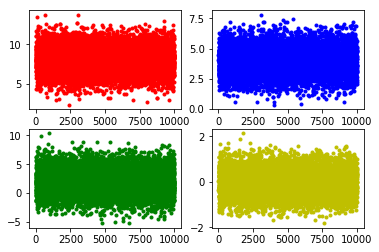

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2)

axs[0,0].plot(np.asarray(a),'r.')
axs[1,0].plot(np.asarray(b),'g.')
axs[0,1].plot(np.asarray(c),'b.')
axs[1,1].plot(np.asarray(d),'y.')

In [13]:
series1 = np.rollaxis(np.asarray(y1),1)
series2 = np.rollaxis(np.asarray(y2),1)

In [14]:
# defines the model
model = Sequential()
model.add(Bidirectional())

NameError: name 'Sequential' is not defined

In [19]:
import keras as K

Using TensorFlow backend.


In [20]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense


import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [21]:
def rnn_auto(layer, size, num_encode_layers, num_decode_layers, embedding, n_step, lr = 3e-5, drop_frac=0.,bidirectional=True, l1_norm = 1e-4,**kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    num_encode_layers  : numpy, int
        sets the number of encoding layers in the network
    num_decode_layers : numpy, int
        sets the number of decoding layers in the network
    embedding : numpy, int
        sets the size of the embedding layer
    n_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidirectional : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    # defines the model
    model = Sequential()

    # selects if the model is bidirectional
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))

    # builds the encoding layers
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. The batch
        size is limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                             save_weights_only=True, mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data1), np.atleast_3d(data2), epochs=250000,
          batch_size=1200, validation_data=(np.atleast_3d(data), np.atleast_3d(data)),
          callbacks=[tbCallBack, checkpoint])


In [22]:
auto_test = rnn_auto(LSTM, 64, 1, 1, 10, 100)

In [23]:
# fits the model
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=2500, batch_size=2000)

Epoch 1/2500
10000/10000 [==============================] - 6s 573us/step - loss: 116.2660
Epoch 2/2500
10000/10000 [==============================] - 4s 405us/step - loss: 115.7290
Epoch 3/2500
10000/10000 [==============================] - 4s 401us/step - loss: 115.1686
Epoch 4/2500
10000/10000 [==============================] - 4s 395us/step - loss: 114.6103
Epoch 5/2500
10000/10000 [==============================] - 4s 388us/step - loss: 114.0656
Epoch 6/2500
10000/10000 [==============================] - 4s 394us/step - loss: 113.5546
Epoch 7/2500
10000/10000 [==============================] - 4s 398us/step - loss: 113.0664
Epoch 8/2500
10000/10000 [==============================] - 4s 388us/step - loss: 112.5759
Epoch 9/2500
10000/10000 [==============================] - 4s 389us/step - loss: 112.0684
Epoch 10/2500
10000/10000 [==============================] - 4s 390us/step - loss: 111.5347
Epoch 11/2500
10000/10000 [==============================] - 4s 380us/step - loss: 110.96

10000/10000 [==============================] - 4s 382us/step - loss: 16.3482
Epoch 91/2500
10000/10000 [==============================] - 4s 381us/step - loss: 16.0953
Epoch 92/2500
10000/10000 [==============================] - 4s 381us/step - loss: 15.8504
Epoch 93/2500
10000/10000 [==============================] - 4s 377us/step - loss: 15.6206
Epoch 94/2500
10000/10000 [==============================] - 4s 377us/step - loss: 15.4015
Epoch 95/2500
10000/10000 [==============================] - 4s 382us/step - loss: 15.1932
Epoch 96/2500
10000/10000 [==============================] - 4s 383us/step - loss: 14.9948
Epoch 97/2500
10000/10000 [==============================] - 4s 378us/step - loss: 14.8063
Epoch 98/2500
10000/10000 [==============================] - 4s 381us/step - loss: 14.6275
Epoch 99/2500
10000/10000 [==============================] - 4s 378us/step - loss: 14.4551
Epoch 100/2500
10000/10000 [==============================] - 4s 383us/step - loss: 14.2907
Epoch 101/25

10000/10000 [==============================] - 4s 377us/step - loss: 10.2074
Epoch 180/2500
10000/10000 [==============================] - 4s 380us/step - loss: 10.1854
Epoch 181/2500
10000/10000 [==============================] - 4s 378us/step - loss: 10.1631
Epoch 182/2500
10000/10000 [==============================] - 4s 378us/step - loss: 10.1403
Epoch 183/2500
10000/10000 [==============================] - 4s 382us/step - loss: 10.1170
Epoch 184/2500
10000/10000 [==============================] - 4s 379us/step - loss: 10.0933
Epoch 185/2500
10000/10000 [==============================] - 4s 382us/step - loss: 10.0686
Epoch 186/2500
10000/10000 [==============================] - 4s 379us/step - loss: 10.0434
Epoch 187/2500
10000/10000 [==============================] - 4s 379us/step - loss: 10.0174
Epoch 188/2500
10000/10000 [==============================] - 4s 378us/step - loss: 9.9904
Epoch 189/2500
10000/10000 [==============================] - 4s 377us/step - loss: 9.9625
Epoch

10000/10000 [==============================] - 4s 376us/step - loss: 5.8399
Epoch 270/2500
10000/10000 [==============================] - 4s 379us/step - loss: 5.8067
Epoch 271/2500
10000/10000 [==============================] - 4s 378us/step - loss: 5.7744
Epoch 272/2500
10000/10000 [==============================] - 4s 382us/step - loss: 5.7429
Epoch 273/2500
10000/10000 [==============================] - 4s 376us/step - loss: 5.7120
Epoch 274/2500
10000/10000 [==============================] - 4s 377us/step - loss: 5.6828
Epoch 275/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.6538
Epoch 276/2500
10000/10000 [==============================] - 4s 379us/step - loss: 5.6247
Epoch 277/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.5967
Epoch 278/2500
10000/10000 [==============================] - 4s 375us/step - loss: 5.5690
Epoch 279/2500
10000/10000 [==============================] - 4s 382us/step - loss: 5.5423
Epoch 280/2500

10000/10000 [==============================] - 4s 378us/step - loss: 4.1405
Epoch 360/2500
10000/10000 [==============================] - 4s 378us/step - loss: 4.1282
Epoch 361/2500
10000/10000 [==============================] - 4s 380us/step - loss: 4.1157
Epoch 362/2500
10000/10000 [==============================] - 4s 379us/step - loss: 4.1034
Epoch 363/2500
10000/10000 [==============================] - 4s 378us/step - loss: 4.0911
Epoch 364/2500
10000/10000 [==============================] - 4s 377us/step - loss: 4.0789
Epoch 365/2500
10000/10000 [==============================] - 4s 378us/step - loss: 4.0669
Epoch 366/2500
10000/10000 [==============================] - 4s 380us/step - loss: 4.0549
Epoch 367/2500
10000/10000 [==============================] - 4s 377us/step - loss: 4.0432
Epoch 368/2500
10000/10000 [==============================] - 4s 379us/step - loss: 4.0311
Epoch 369/2500
10000/10000 [==============================] - 4s 378us/step - loss: 4.0191
Epoch 370/2500

10000/10000 [==============================] - 4s 379us/step - loss: 3.2024
Epoch 450/2500
10000/10000 [==============================] - 4s 380us/step - loss: 3.1945
Epoch 451/2500
10000/10000 [==============================] - 4s 378us/step - loss: 3.1859
Epoch 452/2500
10000/10000 [==============================] - 4s 376us/step - loss: 3.1781
Epoch 453/2500
10000/10000 [==============================] - 4s 381us/step - loss: 3.1696
Epoch 454/2500
10000/10000 [==============================] - 4s 378us/step - loss: 3.1613
Epoch 455/2500
10000/10000 [==============================] - 4s 378us/step - loss: 3.1530
Epoch 456/2500
10000/10000 [==============================] - 4s 379us/step - loss: 3.1451
Epoch 457/2500
10000/10000 [==============================] - 4s 376us/step - loss: 3.1369
Epoch 458/2500
10000/10000 [==============================] - 4s 375us/step - loss: 3.1284
Epoch 459/2500
10000/10000 [==============================] - 4s 379us/step - loss: 3.1201
Epoch 460/2500

KeyboardInterrupt: 

In [24]:
auto_test.save('auto_test')

In [25]:
y1_results = auto_test.predict(np.atleast_3d(y1))

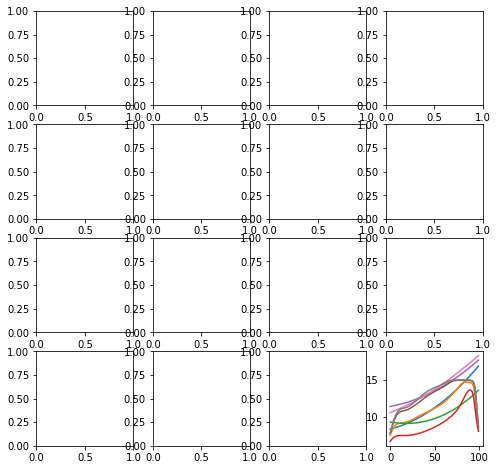

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

axs.reshape(-1)

for _, ax in enumerate(axs):
    
    i = np.random.randint(0, y1_results.shape[0])

    plt.plot(y2[i])
    plt.plot(y1_results[i])